In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/deseq_timepoints/"

In [13]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

In [14]:
# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

In [15]:
mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

## Split according to the comparisons we will do
Between sexes  
Within each sex  
Combined sexes

In [16]:
male_df = mer[mer["Sex"] == "M"]
male_df.drop(columns = ["Sex"], inplace = True)
female_df = mer[mer["Sex"] == "F"]
female_df.drop(columns = ["Sex"], inplace = True)
comb_df = mer[mer["Sex"] == "ALL"]
comb_df.drop(columns = ["Sex"], inplace = True)
sexcomp_df = mer[mer["Sex"] == "vs"]
sexcomp_df.drop(columns = ["Sex"], inplace = True)

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/3668630277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df.drop(columns = ["Sex"], inplace = True)
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/3668630277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_df.drop(columns = ["Sex"], inplace = True)
/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/3668630277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [37]:
x = sexcomp_df[sexcomp_df["Age"] == "Old"]
x[x["Comparison"] == "SexRA"].shape

(77, 17)

In [185]:
lut = dict(zip(['Firmicutes', 'Bacteroidetes', 'Proteobacteria', 'Actinobacteria',
       'Tenericutes', 'Cyanobacteria', 'Patescibacteria',
       'Deferribacteres', 'Fusobacteria'], 
            ["lightgray", "cyan", "gold", "limegreen", "purple", "pink", "orange", "darkolivegreen"]))

In [186]:
def long_and_heatmap(df, nam):
    
    #batches2 = pd.Series(list(df["Phylum"]), index = list(df["OTU"]))
    #lut = dict((k, lut[k]) for k in list(df["Phylum"].unique()))
    #col_batch = batches2.map(lut)

    dfpl = df.loc[:, ["Age", "log2FoldChange", "OTU"]].pivot_table(index = "OTU", 
                        columns = "Age", values = "log2FoldChange")
    dfpl.fillna(0, inplace = True)
    if "Young" in dfpl.columns:
        dfpl = dfpl[["Young",  "Mid", "Old"]]
        sns.set(font="Verdana")
        g = sns.clustermap(dfpl.sort_values(by = ["Young", "Mid", "Old"], ascending = False), 
                       cmap = 'bwr', center = 0, col_cluster = False, row_cluster = False,
                   figsize = [4, 17], yticklabels = False)
    elif "Mid" in dfpl.columns:
        dfpl = dfpl[["Mid", "Old"]]
        sns.set(font="Verdana")
        g = sns.clustermap(dfpl.sort_values(by = ["Mid", "Old"], ascending = False), 
                       cmap = 'bwr', center = 0, col_cluster = False, row_cluster = False,
                   figsize = [3, 17], yticklabels = False)
    else:
        dfpl = dfpl[["Old"]]
        sns.set(font="Verdana")
        g = sns.clustermap(dfpl.sort_values(by = ["Old"], ascending = False), 
                       cmap = 'bwr', center = 0, col_cluster = False, row_cluster = False,
                   figsize = [1.5, 17], yticklabels = False)
    
    g.cax.set_position([1.2, .5, .03, .2])
    g.ax_heatmap.set_xlabel("Age")
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.tick_params(right=False, bottom = False)

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.savefig(f"{path}/{nam}_heatmap_logFC_{new_day}.pdf", bbox_inches='tight')

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


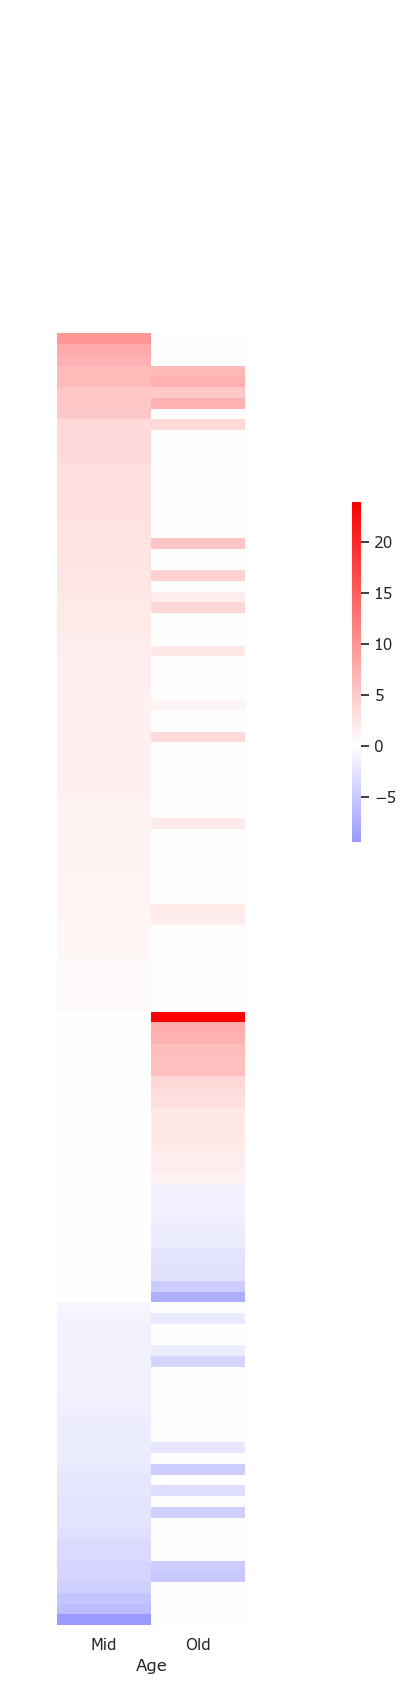

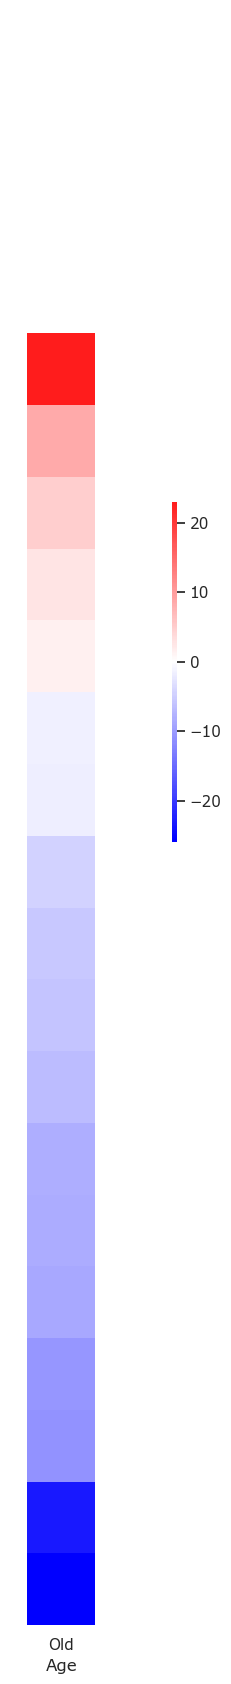

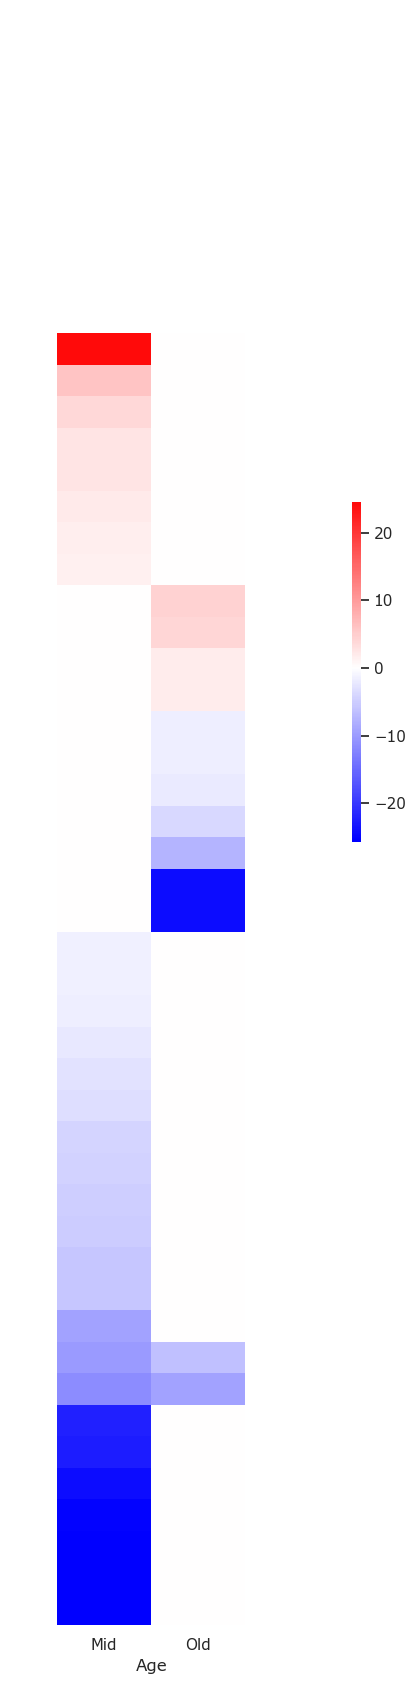

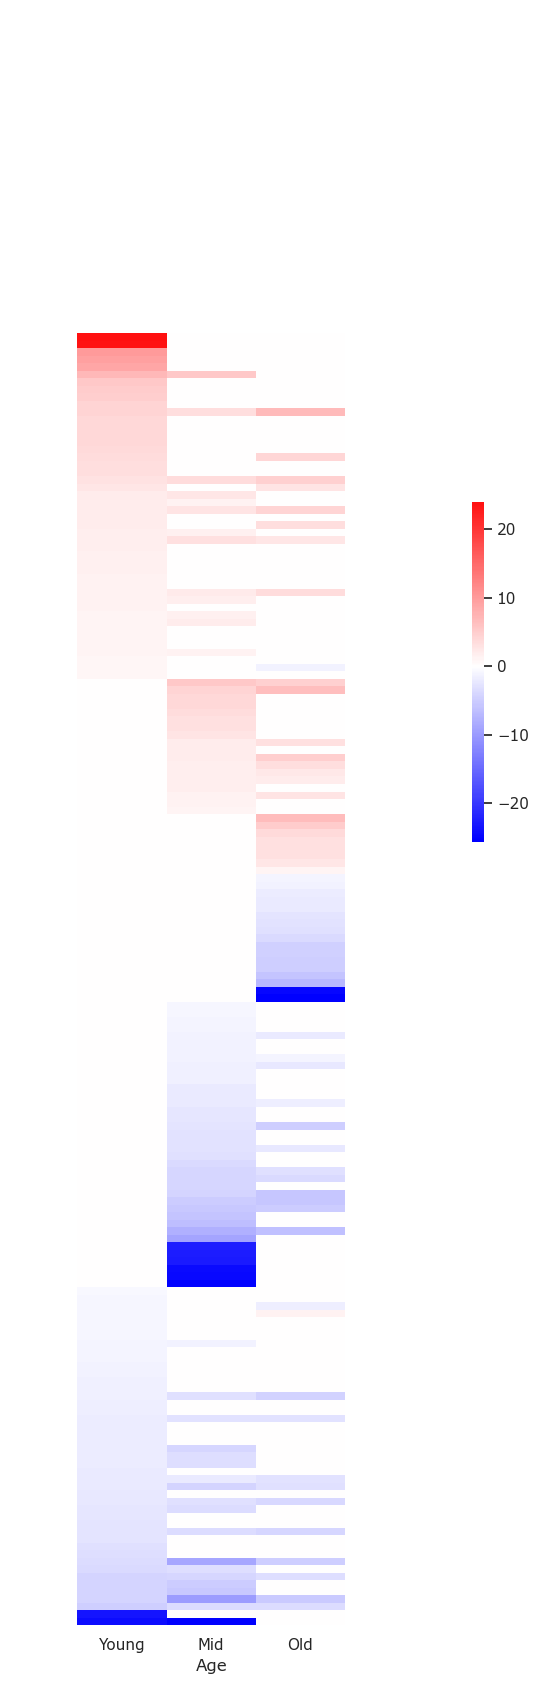

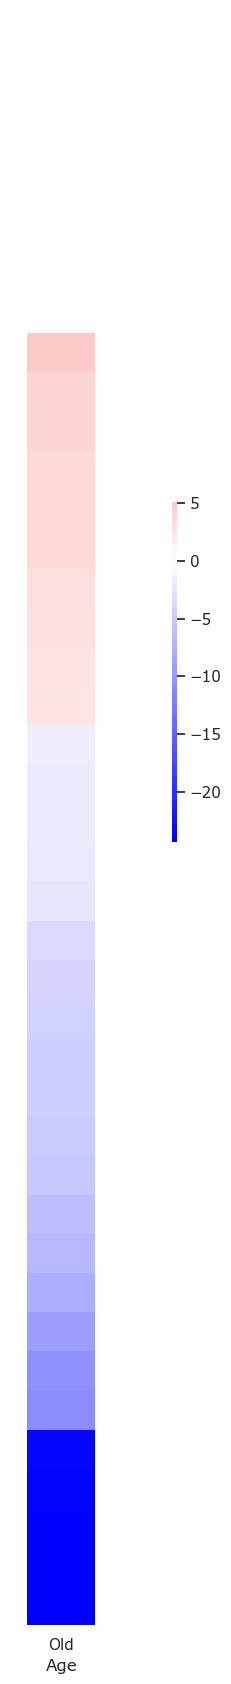

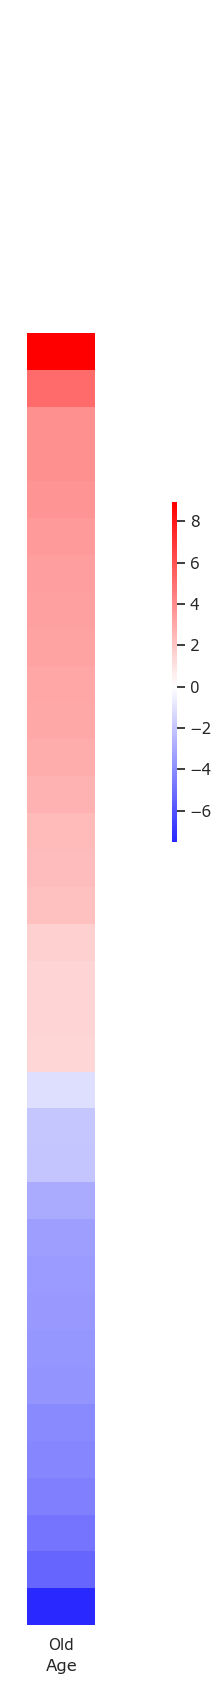

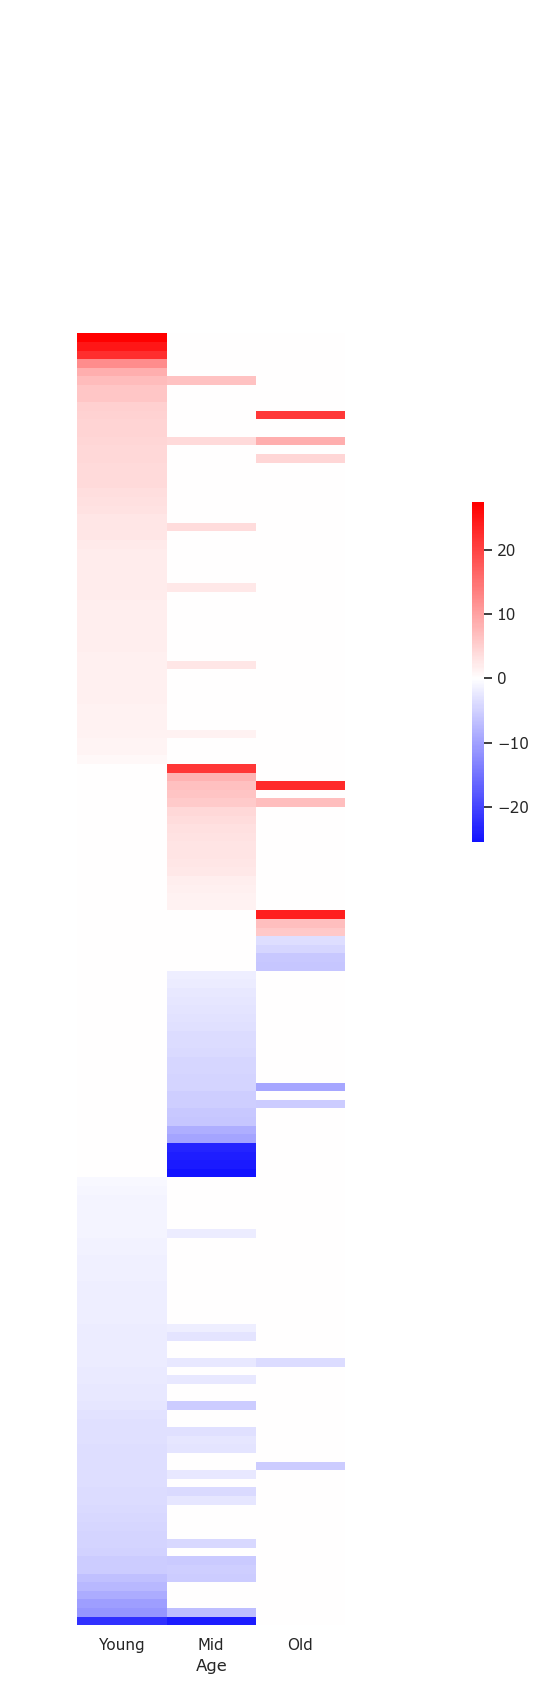

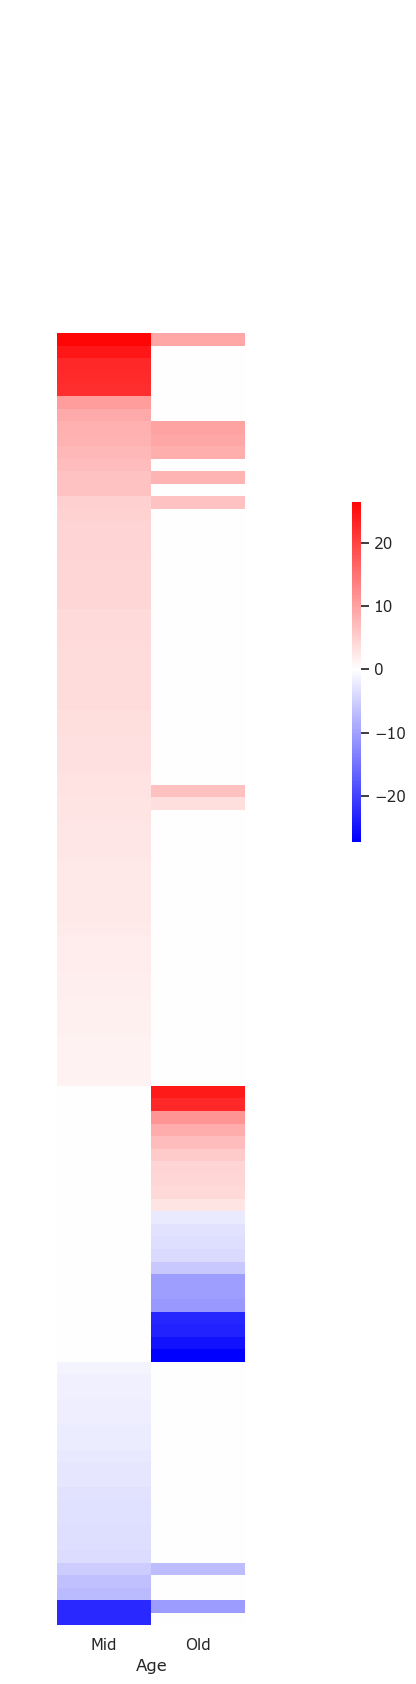

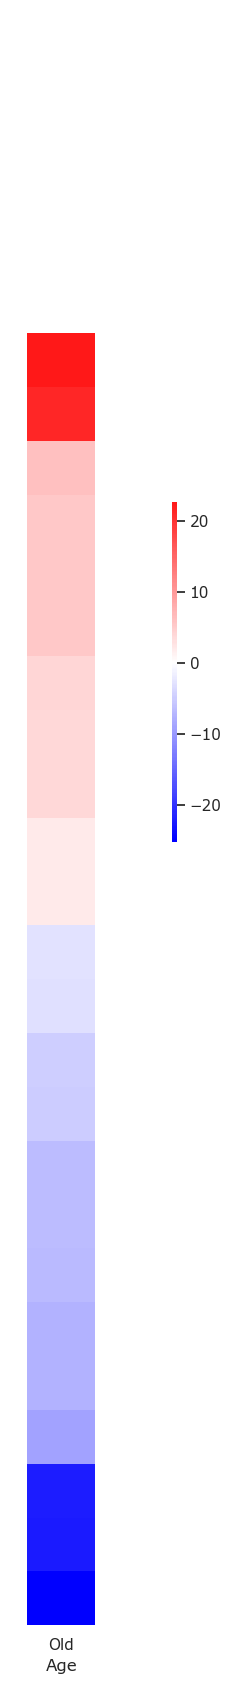

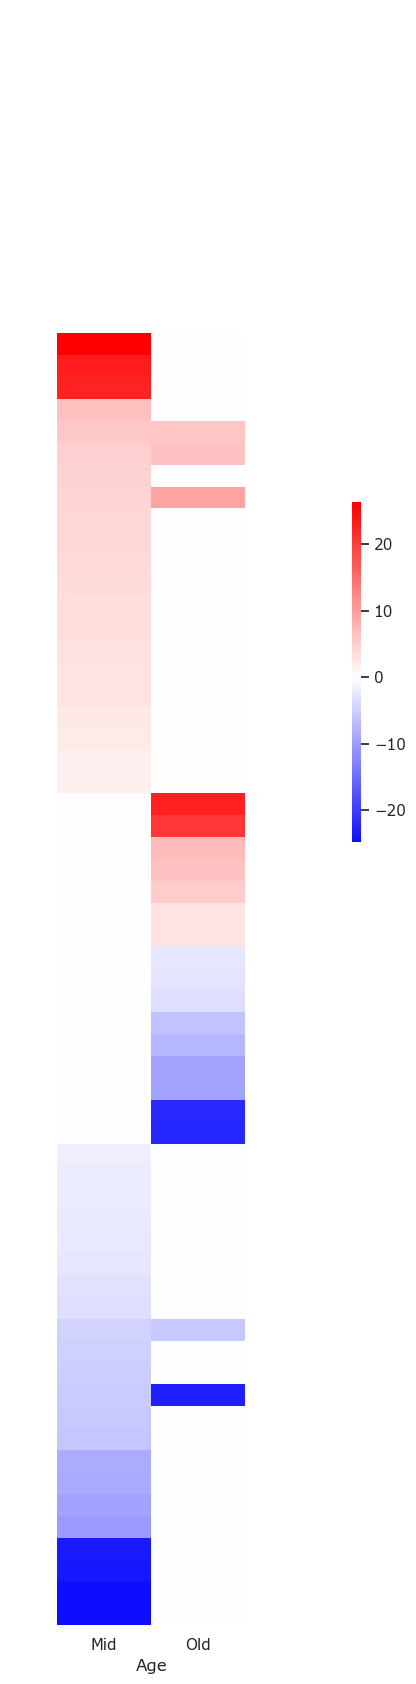

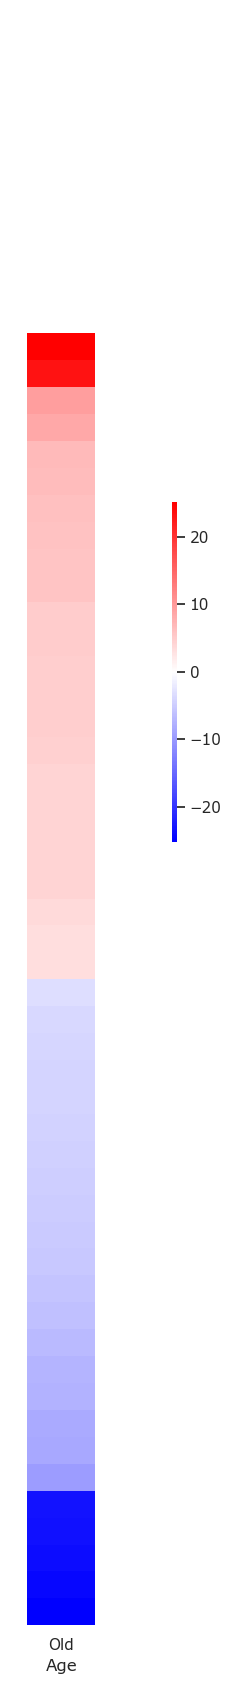

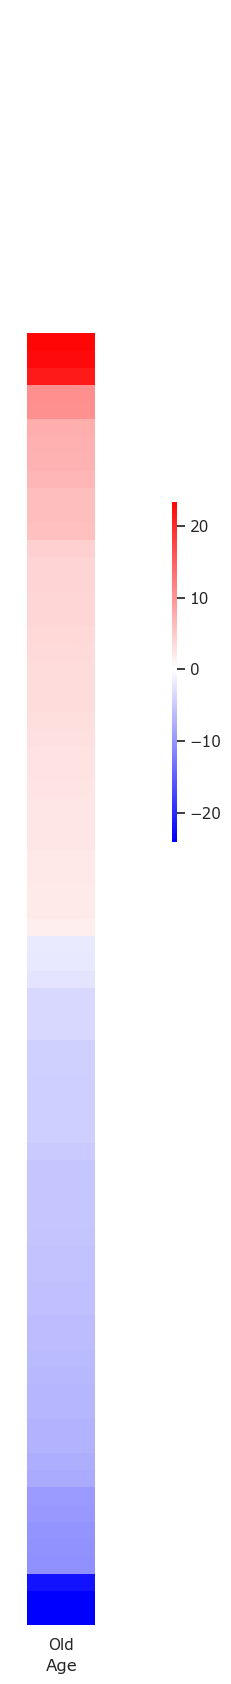

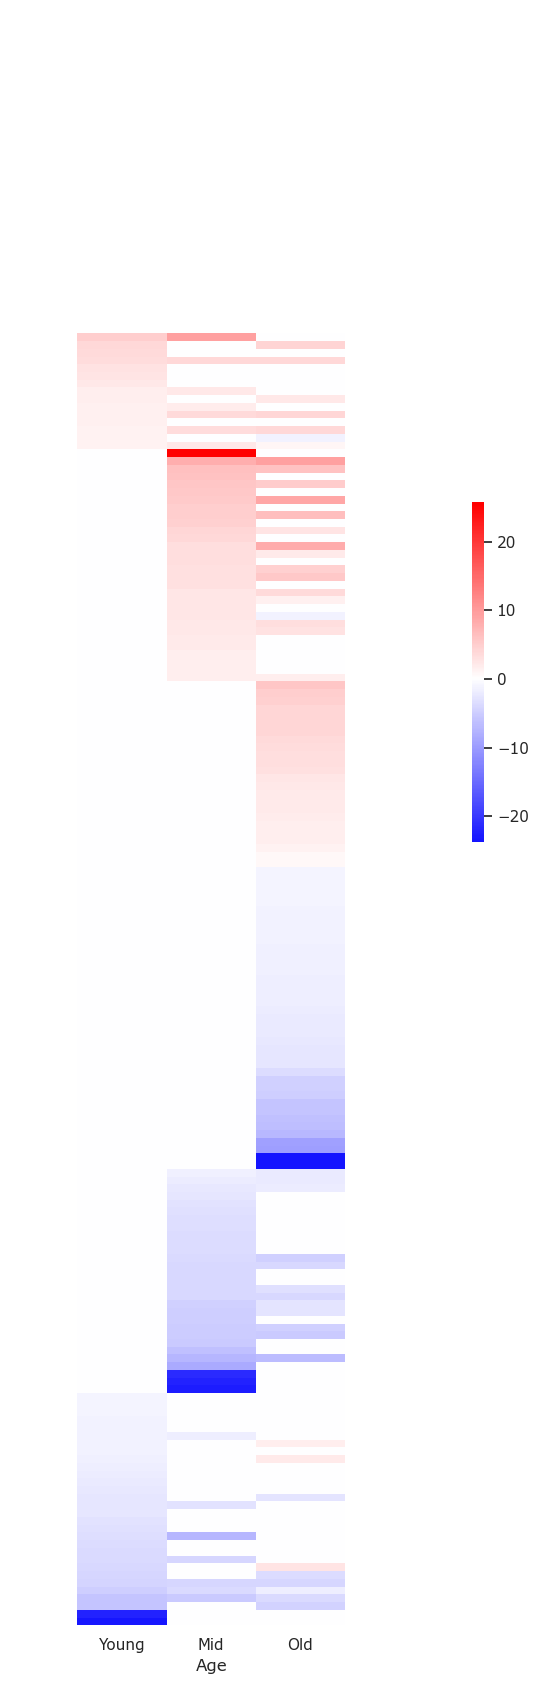

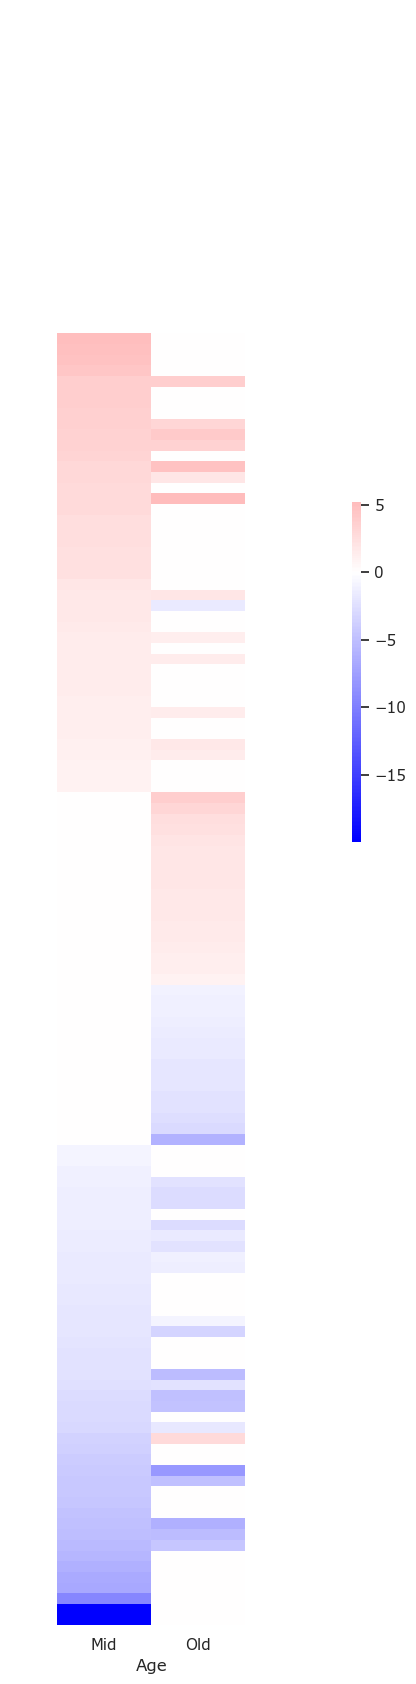

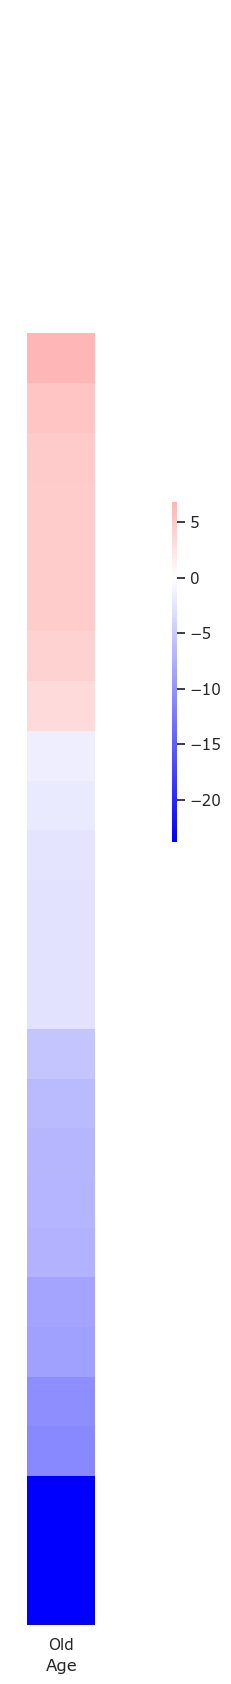

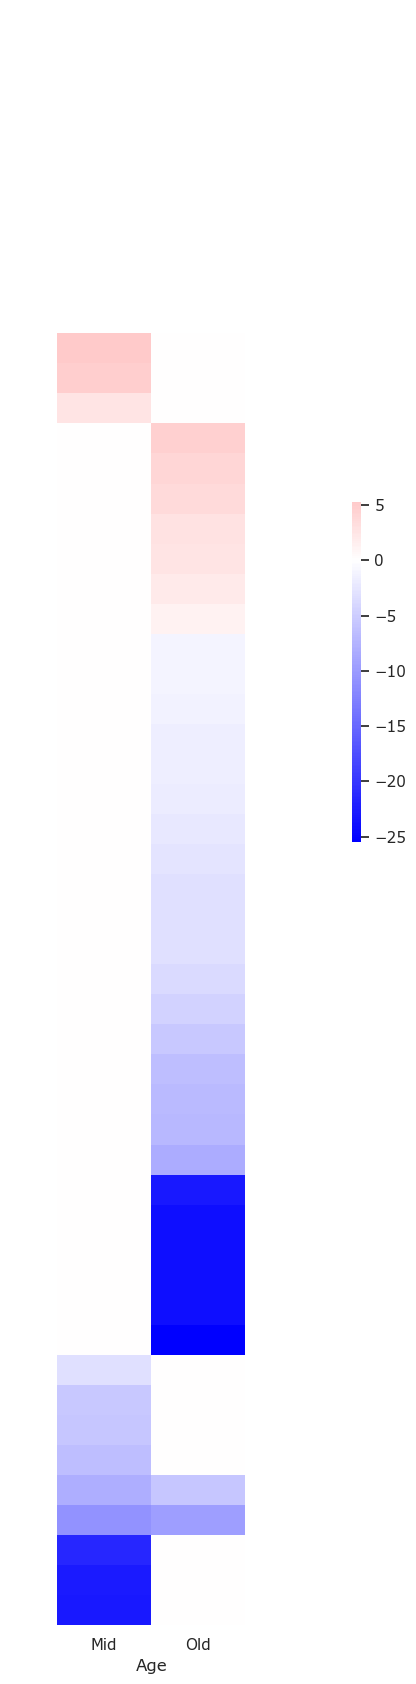

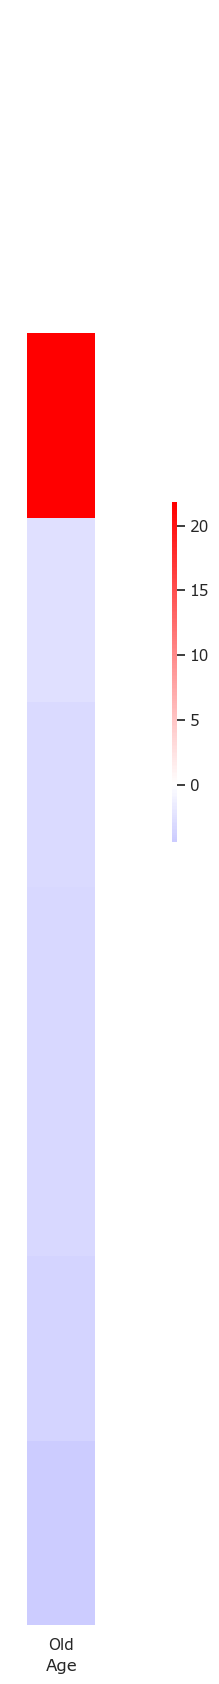

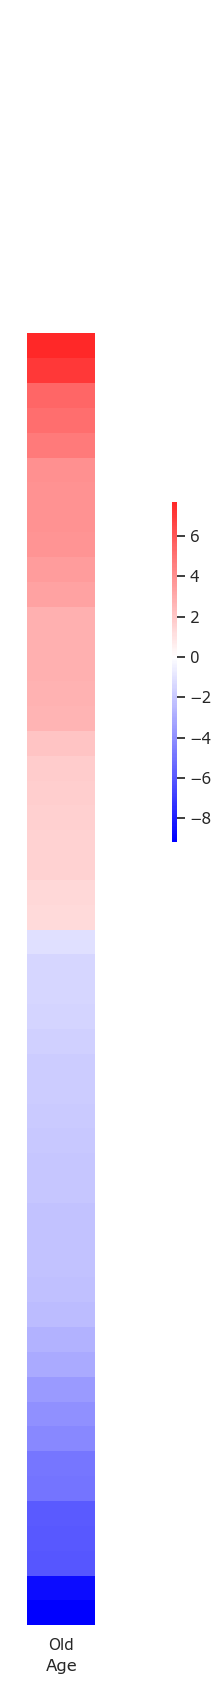

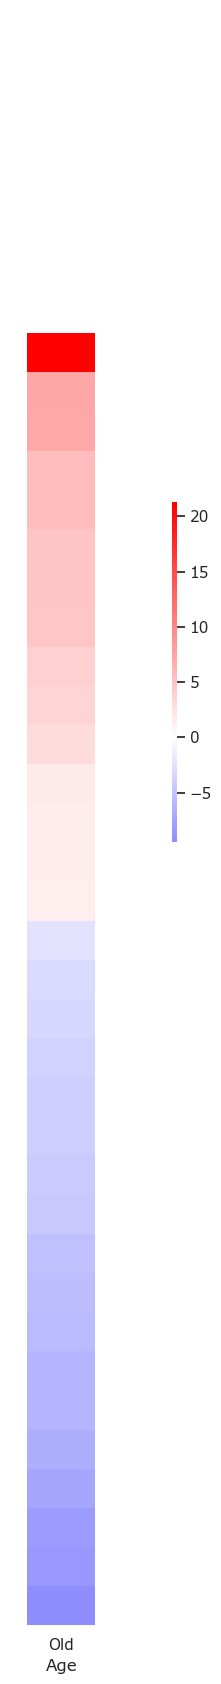

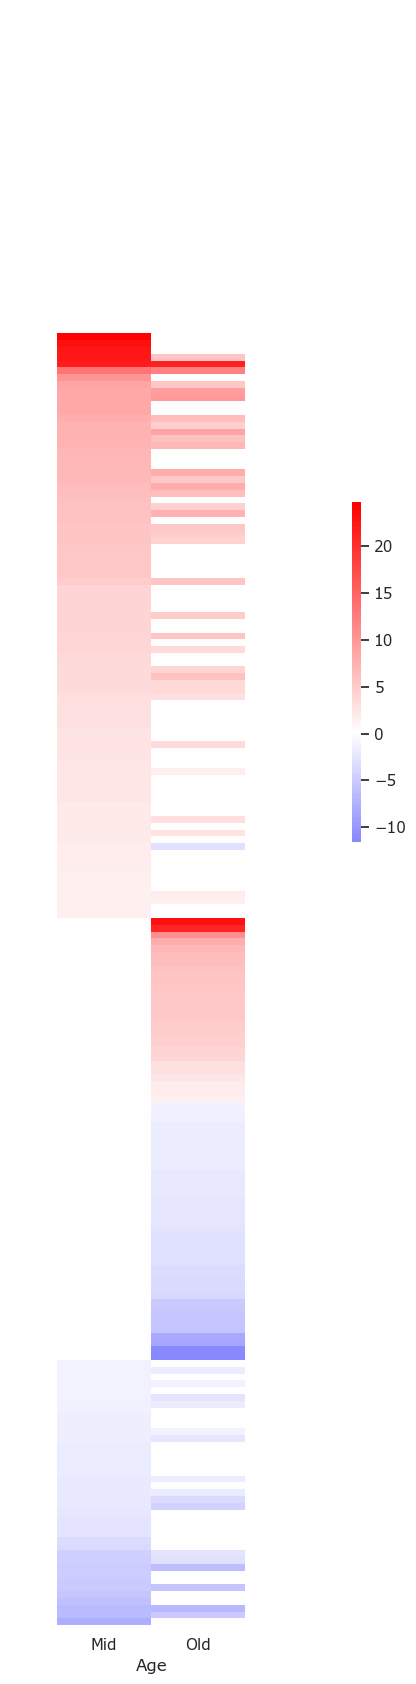

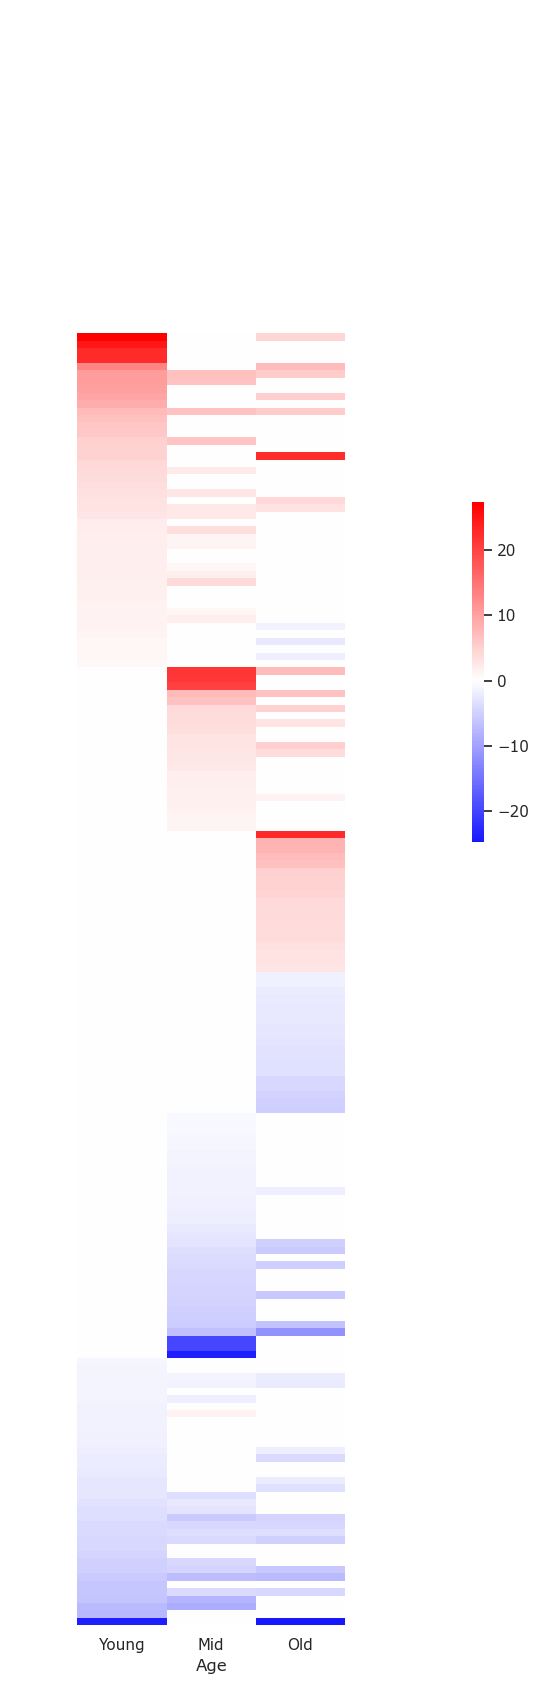

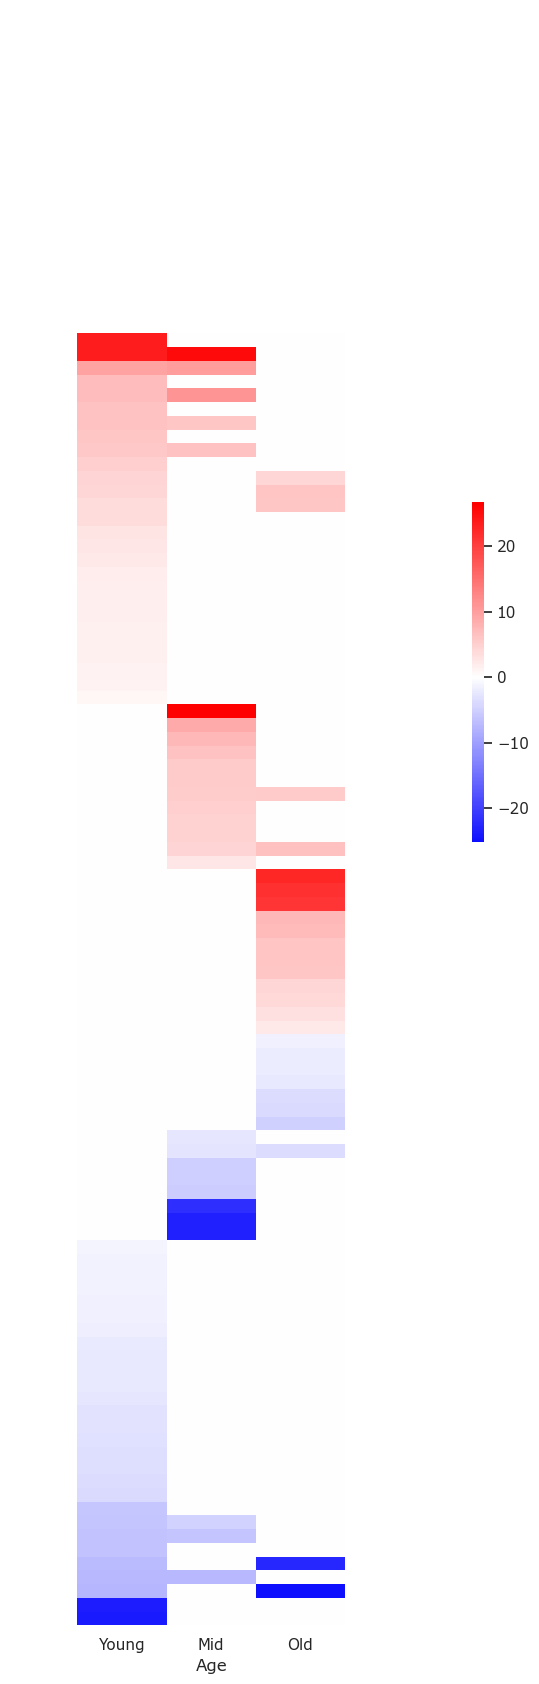

In [187]:
for e in list(comb_df["Comparison"].unique()):

    long_and_heatmap(comb_df[comb_df["Comparison"] == e], e + "_ALL")
    
for e in list(male_df["Comparison"].unique()):

    long_and_heatmap(male_df[male_df["Comparison"] == e], e + "_Males")
    
for e in list(female_df["Comparison"].unique()):

    long_and_heatmap(female_df[female_df["Comparison"] == e], e + "_Females")
    
for e in list(sexcomp_df["Comparison"].unique()):

    long_and_heatmap(sexcomp_df[sexcomp_df["Comparison"] == e], e + "_SexComp")

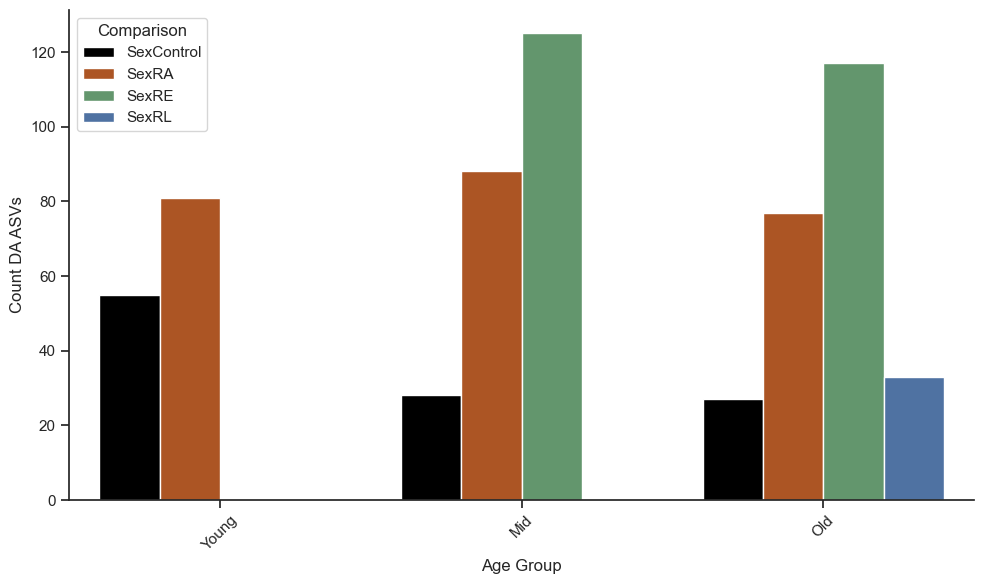

In [228]:
palettesex = {'SexControl': '#000000',
 'SexRA': '#c34e0d',
 'SexRE': '#5a9f68',
 'SexRL': '#4170b0'}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (10, 6))
# Create the bar plot
sns.countplot(sexcomp_df, x="Age", hue="Comparison", hue_order = ["SexControl", "SexRA",
                                                                 "SexRE", "SexRL"],
             palette = palettesex, order = ["Young", "Mid", "Old"])

plt.xlabel("Age Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.show()

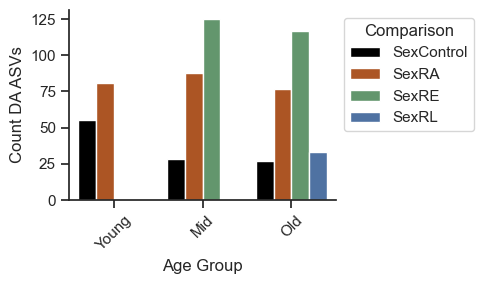

In [229]:
def barplots_numdif(df, hue_order, palette, nam):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    fig, ax = plt.subplots(figsize = (5, 3))
    # Create the bar plot
    sns.countplot(df, x="Age", hue="Comparison", hue_order = hue_order,
                 palette = palettesex, order = ["Young", "Mid", "Old"])

    plt.xlabel("Age Group")
    plt.ylabel("Count DA ASVs")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/{nam}_barplot_difabund_{new_day}.pdf", bbox_inches='tight')
    
barplots_numdif(sexcomp_df, ["SexControl", "SexRA", "SexRE", "SexRL"], palettesex, "sexcomp")

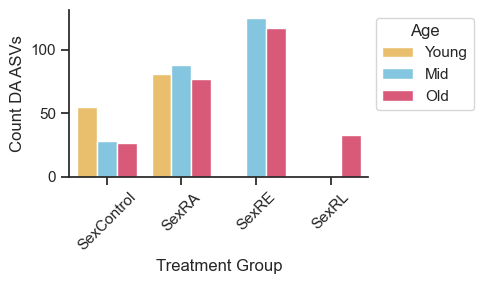

In [230]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

fig, ax = plt.subplots(figsize = (5, 3))
# Create the bar plot
sns.countplot(sexcomp_df, x="Comparison", hue="Age", 
                 hue_order = ["Young", "Mid", "Old"], order = ["SexControl", 
                        "SexRA", "SexRE", "SexRL"], palette = paletteage)

plt.xlabel("Treatment Group")
plt.ylabel("Count DA ASVs")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f"{path}/sexcompbyage_barplot_difabund_{new_day}.pdf", bbox_inches='tight')

In [7]:
female_df

,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,tax,OTU


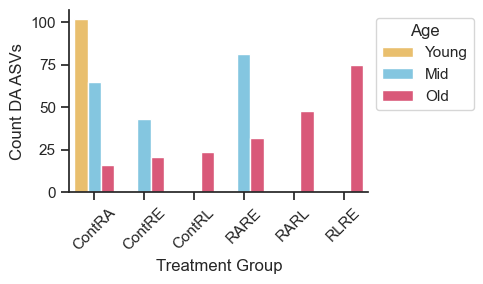

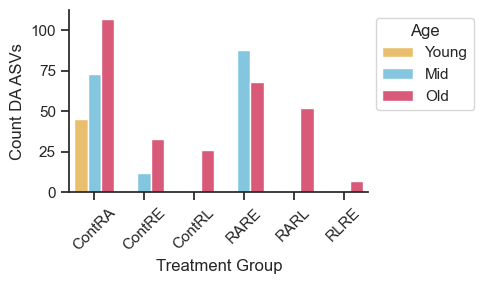

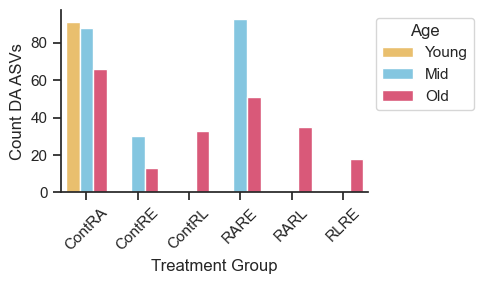

In [233]:
paletteage = {"Young":"#FDC659", "Mid":"#74CDF0", "Old":"#EE446F"}

def barplots_numdif2(df, paletteage, nam):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    fig, ax = plt.subplots(figsize = (5, 3))
    # Create the bar plot
    sns.countplot(df, x="Comparison", hue="Age", 
                 hue_order = ["Young", "Mid", "Old"], order = ["ContRA", "ContRE", "ContRL",
                    "RARE", "RARL", "RLRE"], palette = paletteage)

    plt.xlabel("Treatment Group")
    plt.ylabel("Count DA ASVs")
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(f"{path}/{nam}_barplot_difabund_{new_day}.pdf", bbox_inches='tight')
    
barplots_numdif2(male_df, paletteage, "malecomp")
barplots_numdif2(female_df, paletteage, "femalecomp")
barplots_numdif2(comb_df, paletteage, "combinedcomp")

In [235]:
mer["Genus"].unique() ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']

array(['Lachnospiraceae_NK4A136_group', nan, 'Alistipes',
       'Lachnospiraceae_UCG-001', 'Bacteroides', 'Parasutterella',
       'Roseburia', 'Staphylococcus', 'ASF356', 'Desulfovibrio',
       'Faecalibaculum', 'Acetatifactor', 'Ruminiclostridium_5',
       'Lachnoclostridium', 'Atopostipes', 'Olsenella', 'Aerococcus',
       'Romboutsia', 'Escherichia/Shigella', 'Intestinimonas',
       'Erysipelatoclostridium', 'Oscillibacter', 'Enterorhabdus',
       'Ruminococcaceae_UCG-014', 'Curtobacterium', 'A2', 'Anaeroplasma',
       'Ruminiclostridium', 'Lachnospiraceae_UCG-006', 'Butyricicoccus',
       'Lactobacillus', 'Prevotellaceae_UCG-001', 'Bilophila',
       'GCA-900066575', 'Weissella', 'Ruminiclostridium_6', 'Muribaculum',
       'Lachnospiraceae_UCG-004', 'Parvibacter', 'Streptococcus',
       'Alloprevotella', 'Rikenellaceae_RC9_gut_group', 'Odoribacter',
       'Lachnospiraceae_FCS020_group', 'DNF00809',
       'Ruminococcaceae_UCG-003', 'Candidatus_Arthromitus',
       'Rumi

In [238]:
for e in ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']:
    display(mer[mer["Genus"] == e])

,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
329,TACGTAGGTGGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGGATG...,1.879857,-4.466720,1.616498,-2.763208,0.005724,0.036402,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Candidatus_Arthromitus,RARE,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_C...,ASV_694
591,TACGTAGGTGGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGGATG...,2.417387,4.676004,1.660519,2.815990,0.004863,0.026683,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Candidatus_Arthromitus,SexRE,Old,vs,Bacteria_Firmicutes_Clostridia_Clostridiales_C...,ASV_694
1827,TACGTAGGTGGCAAGCGTTGTTCGGAATAACTGGGCGTAAAGGATG...,3.238892,-5.191362,1.850142,-2.805925,0.005017,0.038459,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Candidatus_Arthromitus,RLRE,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_C...,ASV_694


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
3,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,419.120484,-2.931407,0.957131,-3.062702,2.193487e-03,2.790862e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_20
11,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,158.110274,-3.256431,0.999686,-3.257455,1.124161e-03,1.694481e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_55
71,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,237.818324,11.352932,2.561599,4.431970,9.337583e-06,2.422584e-04,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RARE,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_133
84,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,55.975751,8.657417,2.433832,3.557114,3.749521e-04,7.959210e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RARE,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_279
121,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,23.813909,7.503068,2.139857,3.506341,4.543136e-04,7.356949e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RARE,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_133
138,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,5.848929,6.022405,1.931544,3.117923,1.821302e-03,2.229984e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RARE,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_279
184,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,26.081518,-8.008565,2.158363,-3.710481,2.068655e-04,1.015365e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RLRE,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_133
192,TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,6.347513,-8.466627,2.081363,-4.067829,4.745324e-05,3.105551e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RLRE,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_279
231,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,15.782163,5.035027,1.594798,3.157156,1.593159e-03,2.270252e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,ContRA,Young,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_341
252,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,1157.702381,3.744980,0.728649,5.139622,2.752912e-07,1.641424e-05,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-001,RARE,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_20


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
32,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,12.294253,3.119816,1.004301,3.106455,1.893449e-03,2.553304e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
53,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,7.004207,-3.834853,1.140621,-3.362076,7.735892e-04,1.321732e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
79,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,35.243790,-3.499621,1.171843,-2.986425,2.822598e-03,4.252107e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,RARE,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
176,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,12.011195,-3.348990,1.109026,-3.019757,2.529773e-03,3.566980e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,SexRL,Old,vs,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
395,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,37.131315,2.479351,0.623238,3.978175,6.944628e-05,1.011056e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ContRA,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
421,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,1.378864,3.954017,1.425541,2.773697,5.542333e-03,3.266018e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ContRA,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
473,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,10.236615,6.808632,1.092552,6.231860,4.609290e-10,5.577241e-08,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ContRL,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375
525,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,31.219504,-3.642751,0.799645,-4.555458,5.227145e-06,1.264471e-04,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,SexRE,Old,vs,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
859,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,38.377005,2.299360,0.587272,3.915322,9.028381e-05,1.477645e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,ContRA,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_216
953,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTG...,5.617256,3.394217,1.057897,3.208458,1.334487e-03,1.250163e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_5,RARE,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_R...,ASV_375


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
33,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,20.060686,-2.463284,0.856269,-2.876766,4.017740e-03,3.875175e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_217
34,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,17.429264,-2.433752,0.667681,-3.645082,2.673062e-04,5.512038e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_220
43,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,3.766065,-5.237628,1.742883,-3.005151,2.654491e-03,3.112521e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_276
50,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,17.495174,-1.957903,0.565690,-3.461087,5.379982e-04,9.749180e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_346
82,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,45.759801,8.516022,1.493897,5.700540,1.194283e-08,4.290231e-07,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RARE,Old,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,58.858890,-1.792343,0.470140,-3.812362,1.376453e-04,5.340639e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,ContRL,Old,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_220
2014,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,126.621223,-3.146528,0.703709,-4.471350,7.772734e-06,1.651706e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,RLRE,Old,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_138
2048,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,20.111794,-1.729732,0.542410,-3.188975,1.427781e-03,4.334336e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,ContRE,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_346
2093,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,9.153870,1.501746,0.488313,3.075374,2.102388e-03,2.371298e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,SexControl,Young,vs,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_346


,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
0,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,1358.127264,-3.246123,1.118593,-2.901970,3.708236e-03,3.635287e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_10
10,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,32.515604,-7.018034,1.328028,-5.284551,1.260134e-07,6.279667e-06,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_46
15,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,38.565205,-25.484636,2.921450,-8.723283,2.702507e-18,8.080496e-16,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_84
16,TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGAG...,335.710063,2.809871,0.746646,3.763323,1.676706e-04,3.580964e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_88
24,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,6.750087,5.633647,1.730702,3.255123,1.133432e-03,1.694481e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRA,Mid,M,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,133.434094,-11.550274,1.356624,-8.513981,1.680615e-17,2.040746e-15,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRE,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_46
2056,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,5.822358,-5.797876,1.781639,-3.254238,1.136972e-03,3.717023e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ContRE,Mid,ALL,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_457
2064,TACGTAGGGGGCAAGCGTTATCCGGATTCACTGGGTGTAAAGGGAG...,71.109944,1.444126,0.458517,3.149558,1.635175e-03,2.033487e-02,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,SexControl,Young,vs,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_89
2079,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,42.001904,2.652597,0.710171,3.735155,1.875998e-04,3.791079e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,SexControl,Young,vs,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_227


In [55]:
x = male_df[male_df["Age"] == "Young"]
maleyoung = x[x["Comparison"] == "ContRA"]["OTU"]
x = male_df[male_df["Age"] == "Mid"]
malemid = x[x["Comparison"] == "ContRA"]["OTU"]
x = male_df[male_df["Age"] == "Old"]
maleold = x[x["Comparison"] == "ContRA"]["OTU"]

x = female_df[female_df["Age"] == "Young"]
femaleyoung = x[x["Comparison"] == "ContRA"]["OTU"]
x = female_df[female_df["Age"] == "Mid"]
femalemid = x[x["Comparison"] == "ContRA"]["OTU"]
x = female_df[female_df["Age"] == "Old"]
femaleold = x[x["Comparison"] == "ContRA"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/2702403539.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


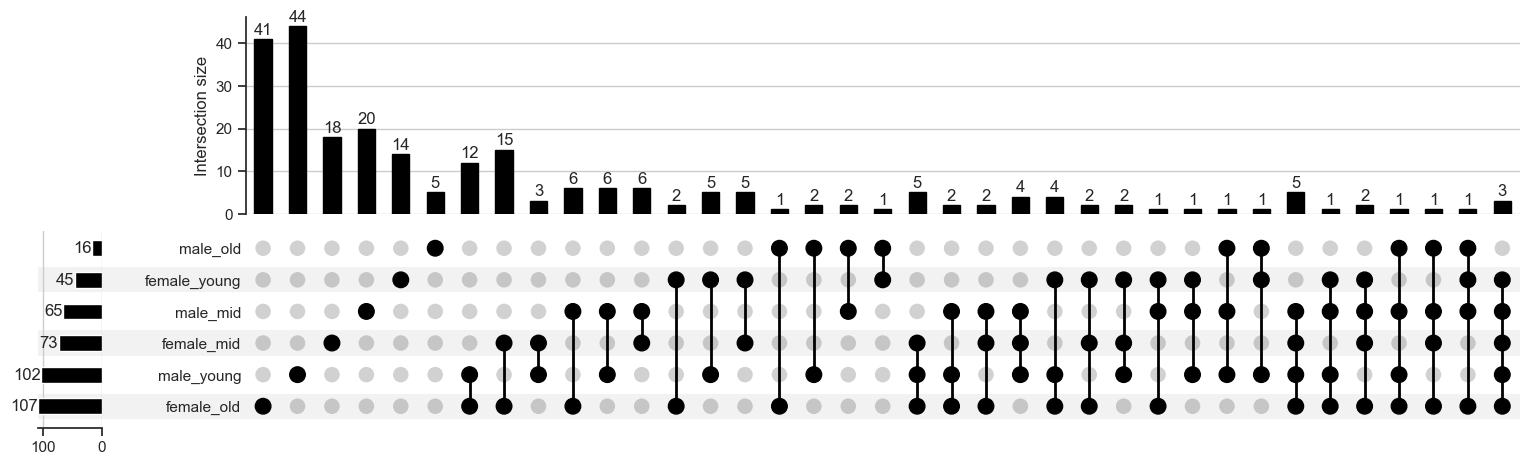

In [68]:
from upsetplot import UpSet
changes = from_contents(
    {"female_young": femaleyoung, "female_mid": femalemid, "female_old": femaleold,
    "male_young":maleyoung, "male_mid":malemid, "male_old":maleold}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("all_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/1201158616.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


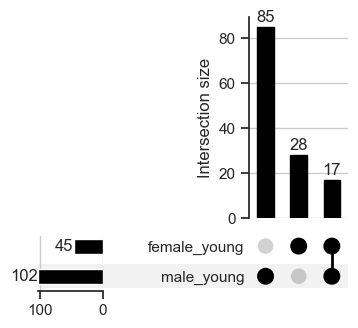

In [65]:
changes = from_contents(
    {"male_young":maleyoung, "female_young":femaleyoung}
)
ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("young_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/1432408389.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


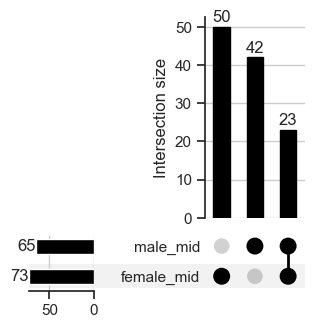

In [69]:
changes = from_contents(
    {"male_mid":malemid, "female_mid":femalemid}
)
ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("mid_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/2830356902.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


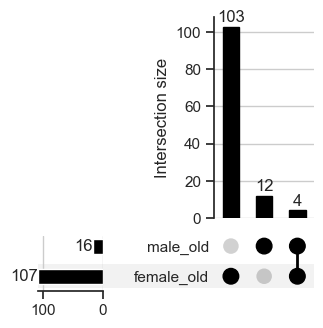

In [70]:
changes = from_contents(
    {"male_old":maleold, "female_old":femaleold}
)
ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("old_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/1105282720.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


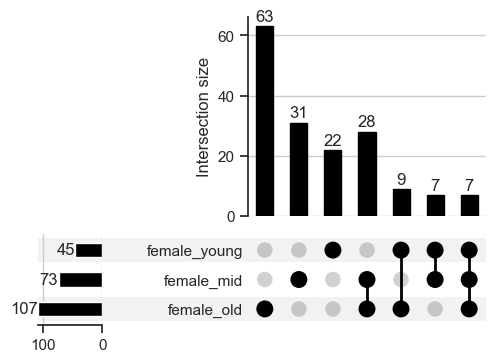

In [71]:
changes = from_contents(
    {"female_young": femaleyoung, "female_mid": femalemid, "female_old": femaleold}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("females_ContRA.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_2993/2352233706.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


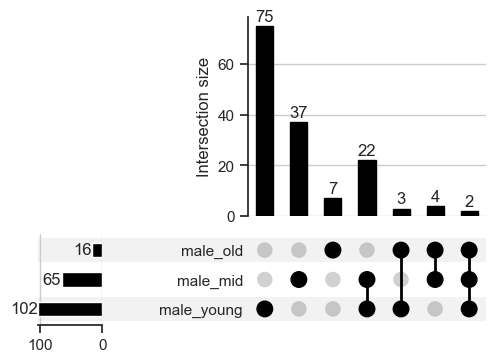

In [72]:
changes = from_contents(
    {"male_young": maleyoung, "male_mid": malemid, "male_old": maleold}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("males_ContRA.pdf")